![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [15]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


bagreg = BaggingRegressor(DecisionTreeRegressor(max_features = 'log2'), n_estimators=10, 
                          bootstrap=True, oob_score=True, random_state=1)
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
mse_BG_sk = mean_squared_error(y_test, y_pred)
MAE_BG_sk = mean_absolute_error(y_test, y_pred)
RMSE_BG_sk = np.sqrt(mse_BG_sk)
MAPE_BG_sk = mean_absolute_percentage_error(y_test, y_pred)

print("Error cuadrático medio (RMSE):", RMSE_BG_sk)
print("Error absoluto medio (MAE):", MAE_BG_sk)
print("Error porcentual absoluto medio (MAPE):", MAPE_BG_sk)

Error cuadrático medio (RMSE): 1824.7000069648657
Error absoluto medio (MAE): 1361.8777493561897
Error porcentual absoluto medio (MAPE): 0.09881386853149371


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Variación de hiper parametros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}

# Creamos el modelo Random Forest
rf = RandomForestRegressor(random_state=42)

# Buscamos el mejor conjunto de hiperparámetros mediante Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Imprimimos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluamos el modelo en el conjunto de prueba
y_pred = grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Imprimimos el RMSE y el MAE
print("RMSE:", rmse)
print("MAE:", mae)


Mejores hiperparámetros: {'max_depth': 10, 'n_estimators': 100}
RMSE: 1583.6492233928598
MAE: 1164.5609588027446


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

El mejor valor de max_depth es: 8


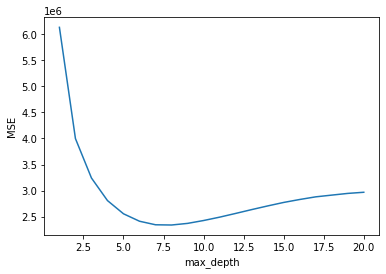

In [31]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 21)

# Definición de lista para almacenar el MSE promedio por valor de max_depth
mse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rf = RandomForestRegressor(max_depth=depth, random_state=1, n_jobs=-1)
    mse_scores.append(-1 * cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, mse_scores)
plt.xlabel('max_depth')
plt.ylabel('MSE')

optimal_max_depth = depth_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de max_depth es:", optimal_max_depth)


**max_depth**: El parámetro controla la profundidad máxima del árbol de decisión en cada estimador de Random Forest. Un valor más alto de "max_depth" permite que el modelo se ajuste más a los datos de entrenamiento, pero también puede aumentar la posibilidad de sobreajuste. Por lo tanto, un valor óptimo de "max_depth" en este caso  es de 8, en donde tenemos el valor minimo de la curva.

El mejor valor de max_features es: 4


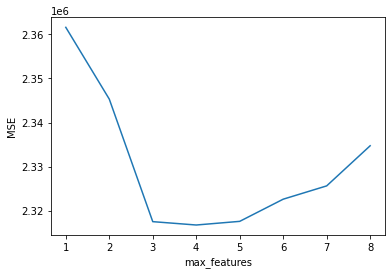

In [32]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1])

# Definición de lista para almacenar el MSE promedio para cada valor de max_features
mse_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf = RandomForestRegressor(max_features=feature, max_depth=optimal_max_depth ,random_state=1, n_jobs=-1)
    mse_scores.append(-1 * cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, mse_scores)
plt.xlabel('max_features')
plt.ylabel('MSE')

optimal_max_features = feature_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de max_features es:", optimal_max_features)

**max_features**: El parámetro controla el número máximo de características que se consideran para dividir un nodo en el árbol de decisión. Un valor más bajo de  reduce la complejidad del modelo y puede ayudar a prevenir el sobreajuste, mientras que un valor más alto puede mejorar el rendimiento del modelo en conjuntos de datos con muchas características relevantes, en este caso se selecciona el optimo

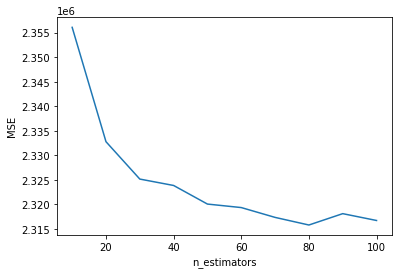

El mejor valor de n_estimators es: 80


In [33]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 101, 10)

# Definición de lista para almacenar el MSE promedio para cada valor de n_estimators
mse_scores = []

# Iterar sobre diferentes valores de n_estimators
for estimator in estimator_range:
    # Crear un modelo de regresión random forest con el número de estimadores dado y otros parámetros fijos
    rf = RandomForestRegressor(n_estimators=estimator ,max_features=optimal_max_features, max_depth=optimal_max_depth ,random_state=1, n_jobs=-1)
    # Calcular el MSE promedio utilizando 10-fold cross-validation
    mse_scores.append(-1 * cross_val_score(rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, mse_scores)
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.show()

# Obtener el valor óptimo de n_estimators con el menor MSE promedio
optimal_n_estimators = estimator_range[mse_scores.index(min(mse_scores))]
print("El mejor valor de n_estimators es:", optimal_n_estimators)

**n_estimators**: controla el número de árboles que se construyen en el modelo de Random Forest. Un valor más alto de estimadores puede mejorar el rendimiento del modelo, pero también aumenta el costo computacional, en este caso vemos que se alcanza el menor cuando la cantidad de estimadores es 80

In [34]:
rf = RandomForestRegressor(n_estimators=optimal_n_estimators ,max_features=optimal_max_features, max_depth=optimal_max_depth ,random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Imprimimos el RMSE y el MAE
print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 1550.0807439441892
MAE: 1138.942239585836


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [24]:
from xgboost import XGBRegressor
XG_reg = XGBRegressor()

XG_reg.fit(X_train, y_train)

y_pred= XG_reg.predict(X_test)

mse_XG = mean_squared_error(y_test, y_pred)
MAE_XG = mean_absolute_error(y_test, y_pred)
RMSE_XG = np.sqrt(mse_XG)
MAPE_XG = mean_absolute_percentage_error(y_test, y_pred)

print("Error cuadrático medio (RMSE):", RMSE_XG)
print("Error absoluto medio (MAE):", MAE_XG)
print("Error porcentual absoluto medio (MAPE):", MAPE_XG)


Error cuadrático medio (RMSE): 1621.4197004256812
Error absoluto medio (MAE): 1186.634392366123
Error porcentual absoluto medio (MAPE): 0.0864887239331454


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [25]:
from sklearn.model_selection import GridSearchCV
XG_reg = XGBRegressor()
parametros = {
    'learning_rate': [0.01, 0.1, 0.2],  # Valores para learning_rate
    'gamma': [0, 0.1, 0.2],  # Valores para gamma
    'colsample_bytree': [0.5, 0.7, 1.0]  # Valores para colsample_bytree
}

grid_search = GridSearchCV(XG_reg, parametros, scoring='neg_mean_absolute_percentage_error', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_model_XG_reg = grid_search.best_estimator_

y_pred= best_model_XG_reg.predict(X_test)

bmse_XG = mean_squared_error(y_test, y_pred)
bMAE_XG = mean_absolute_error(y_test, y_pred)
bRMSE_XG = np.sqrt(bmse_XG)
bMAPE_XG = mean_absolute_percentage_error(y_test, y_pred)
print("Mejores parametros:", best_params)
print("Error cuadrático medio (RMSE):", bRMSE_XG)
print("Error absoluto medio (MAE):", bMAE_XG)
print("Error porcentual absoluto medio (MAPE):", bMAPE_XG)

Mejores parametros: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1}
Error cuadrático medio (RMSE): 1547.7444714534906
Error absoluto medio (MAE): 1133.055212712453
Error porcentual absoluto medio (MAPE): 0.08230490258758869


Los parámetros más significativos en el análisis de la calibración del sistema XG Boost en este caso son colsample_bytree y gamma. El primero nos muestra que el sistema utilizo el 70% de las características para realizar la división de cada nodo de los diferentes árboles, con ello se reduce la correlación entre los arboles y ayuda a mejorar la generalización del modelo. De igual manera, el parámetro gamma 0.2 es un valor moderado para la creación de nuevos nodos en los árboles, lo que permite obtener arboles más pequeños y menos complejos, asi evitando el overfitting del modelo.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

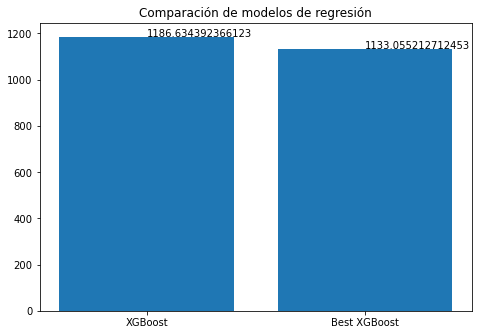

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos de regresión - MAE")
ejeX = ['XGBoost', 'Best XGBoost']
ejeY = [MAE_XG,bMAE_XG]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()
